# Thermal Preference Elicitation Framework

Currently, this framework has been validated for only 1D (operating temp) feature./

# Step 1

Load required modules

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
 
from GPFlowUnimodalPref.GPUnimodalElicit import elicit
from GPFlowUnimodalPref.SynOccupant import datagen

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

# Step 2

1. Occupant walks inside the room and is exposed to state r.
2. Randomly change the state of the room to new state s.
3. Ask the occupant which state they prefer. 
4. If they say state current state s, then record y as 1. If they say previous state r, then record y as 0.
This first duel is our initial duel.
5. Put the duel value and response in the '../data/duels/duels.csv' file

In [2]:
# Load the duels file
occ_name = 'syn_3'
data_file = '../GPFlowUnimodalPref/data/duels/' + occ_name +'.csv' 
config_file = '../GPFlowUnimodalPref/config_files/thermal_config_3.json' 

In [3]:
data = pd.read_csv(data_file)
#data = data.dropna()
data # check if the duels data is as you want it to be

,Tprev,Tcurrent,grad,Y,MEUI
0,21.0,21.0,1,0.0,NaN
1,21.0,23.5,-1,NaN,NaN
2,23.5,22.5,-1,NaN,NaN
3,22.5,21.5,1,NaN,NaN
4,21.5,22.0,0,NaN,NaN


In [4]:
num_data = data.shape[0]

In [5]:
Tprev = np.array(data.Tprev) # previous state (operating temp.)
Tcurrent = np.array(data.Tcurrent) # current state <---- elicitation framework will give you this values
X = np.vstack([[Tprev, Tcurrent]]).T
X = X.astype(float) # features need to be float
#X_prime = np.linspace(18, 27, 20)[:,None]
X_prime = np.arange(18, 30, 0.4)[:,None]
Y_der = np.array(data.grad)[:,None] # response of the occupant <---- you need to ask occupant about this
Y = np.array(data.Y)[:,None]

# Step 3

Now, we want to find the next elicited state. So, we need to use **elicit** module.

In [6]:
trial_num = 10 # this is just to save all the plots in '../data/results/T1' if trial_num = 1 ; T2 if trial_num = 2
model_num = 5
mcmc = True
reachable = True
savefig = False

In [7]:
Aq =  elicit.IntegratedAquisition(X, Y, Y_der, X_prime, config_file, model_num, mcmc, reachable)

----------------------------------------
Model is 5
----------------------------------------
burn-in sampling started
Iteration:  100 	 Acc Rate:  0.0 %
Iteration:  200 	 Acc Rate:  4.0 %
Iteration:  300 	 Acc Rate:  42.0 %
Iteration:  400 	 Acc Rate:  36.0 %
Iteration:  500 	 Acc Rate:  59.0 %
Iteration:  600 	 Acc Rate:  49.0 %
Iteration:  700 	 Acc Rate:  36.0 %
Iteration:  800 	 Acc Rate:  44.0 %
Iteration:  900 	 Acc Rate:  45.0 %
Iteration:  1000 	 Acc Rate:  53.0 %
Iteration:  1100 	 Acc Rate:  52.0 %
Iteration:  1200 	 Acc Rate:  41.0 %
Iteration:  1300 	 Acc Rate:  54.0 %
Iteration:  1400 	 Acc Rate:  47.0 %
Iteration:  1500 	 Acc Rate:  60.0 %
Iteration:  1600 	 Acc Rate:  47.0 %
Iteration:  1700 	 Acc Rate:  73.0 %
Iteration:  1800 	 Acc Rate:  43.0 %
Iteration:  1900 	 Acc Rate:  30.0 %
Iteration:  2000 	 Acc Rate:  24.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  31.0 %
Iteration:  200 	 Acc Rate:  46.0 %
Iteration:  300 	 Acc Rate:  45.0 %
Iteration:  400 	 Acc 

In [8]:
next_state, next_duel, meanexp, max_exp_imp = Aq.EUI(num_data, trial_num, savefig=False)

## Step 3 is the most important step. It outputs next state.

# next_state ?

In [9]:
next_state

array([ 22.])

# next duel ?

One of the state is always shared between two duels. So, this is nothing but concatenation of next_state with previous.

In [10]:
next_duel

array([ 22.,  22.])

# Next response

In [11]:
V = datagen.ThermalPrefDataGen(config_file)
Ynew = V.response_grad_gen1D(next_duel[:,None].T)
print Ynew

[ 1.]


# max EUI ?

In [12]:
max_exp_imp

0.007640960046604816

In [13]:
meanexp

array([  2.52118353e-04,   7.67950432e-04,   2.26246970e-03,
         5.46043023e-03,   7.64096005e-03,   5.48338812e-03,
         2.24469382e-03,   7.61640085e-04,   2.60166138e-04,
         8.97561821e-05])

# Step 4 (Sanity checks)

Is our framework on the right track?

Check -
1. Max Expected Improvement value (is it less than the previous iteration's expected improvement? If so, GOOD!
2. Check the Expected Improvement plots. This will be saved automatically in '../data/results/T1/exp_imp_plots/iteration_num'.
3. Also check utility samples, how they look? Do they make sense? Is our framework going towards max? Some utility samples will also be saved in '../data/results/T1/utility_samples/iteration_num'.

# Step 5

1. Once you have verified that the framework is on the right track, change the operating temp of the room to the next_state as above. 
2. Its fine if you are not able to acheive the next state accurately, just record the measured next state value.
2. Ask the occupant again, which state does he prefer.
3. Add the new measured state and response to the csv  '../data/duels/duels.csv' file.
4. Add max_exp_imp to the MEUI column.
5. Run the notebook again with updated csv file.
6. As you progress with the elicitation, you will notice that the ratio $(MEUI_{(i+1)} - MEUI_{(i)})/MEUI_{(i)}$ will decrease. Based on pilot study, stop the elicitation, once the ratio becomes small enough.

In [14]:
Aq.m

Name,values,prior,constraint
unimodal_model.Vf,[[ 0.72709549] [-0.15133835] [ 0.23919031] [ 1.01687797] [-0.81726618] [ 1.9099244 ] [-0.56364174] [ 0.42685591] [-0.03553704] [-0.57190651] [-0.68911149] [ 0.1957448 ] [ 0.12480292] [-1.67334818] [ 0.80476577] [ 0.80345038] [ 0.10117976] [-1.17890746] [ 0.4163683 ] [ 0.34989162] [-1.6464647 ] [ 0.49453716] [-0.13364058] [-1.05213572] [-1.77016776] [ 0.64522101] [-1.53115807] [-0.2750251 ] [-0.42533345] [ 0.59960808] [ 0.36609994] [ 1.17059921] [ 0.20047014] [-0.58703061] [ 0.53469956] [ 1.94462947] [ 0.5700972 ]],"N([ 0.],[ 1.])",(none)
unimodal_model.Vfdd,[[ 11.76248472] [ -4.81085087] [ -0.85501797] [ 1.41100949] [ -2.00912371] [ -8.30357611] [ 12.67321272] [ 1.83929366] [ 2.63964932] [ 7.25536978] [ 10.80181664] [ 0.67992628] [ 10.8129922 ] [ 2.51266597] [ 9.17824776] [-12.69425284] [ 5.01076248] [ 0.65749928] [ 4.00693408] [ -3.00487756] [ 9.60575655] [ -5.51645443] [ -5.9272257 ] [ 2.38023273] [ 7.27369931] [ 0.20243077] [ 23.0004311 ] [ -4.52473616] [-10.18792575] [ 12.89987538] [ -5.94350472] [ -0.76283854] [ 1.50951832] [ 3.60015172] [ -6.66520348]],None,(none)
unimodal_model.Vg,[[ 1.24313206e+00] [ -8.48995907e-01] [ -9.56734391e-02] [ -1.64621276e+00] [ 9.89085920e-01] [ 8.65447004e-02] [ 5.54777031e-01] [ -7.01668444e-01] [ -9.25510354e-01] [ 5.44901561e-01] [ -1.18078688e-01] [ 6.22921211e-01] [ 3.49881087e-01] [ -1.73496243e+00] [ 3.25461893e-01] [ -7.11236711e-01] [ -7.67855307e-01] [ -2.82632278e-02] [ 5.35698488e-01] [ -1.42548797e+00] [ -2.15207548e+00] [ 5.52663727e-01] [ 2.78036812e-01] [ 1.20877816e-01] [ 1.32319807e+00] [ 3.77579998e-01] [ -6.89123630e-01] [ 1.36568399e+00] [ -8.35112630e-01] [ 9.23960327e-01] [ 1.62800833e-03] [ -1.74066563e-01] [ -1.46988967e+00] [ 2.27859845e+00] [ -2.31042755e-01] [ 2.04314972e-01] [ 1.15407769e+00] [ -1.45572381e-01] [ -1.79408188e+00] [ -7.96642444e-01] [ -4.63823741e-01] [ -1.82616031e-01] [ 2.62613670e+00] [ 1.97331623e+00] [ -6.90203820e-01] [ -1.46844232e+00] [ -3.47919442e-03] [ -1.39948386e+00] [ -9.57122995e-02] [ -1.37200187e+00] [ 4.54712147e-01] [ 3.25355832e-01] [ -4.49037772e-01] [ -9.56949899e-01] [ -3.28524281e-01] [ 6.52488210e-01] [ 9.09695842e-02] [ 1.16551225e+00] [ -1.52444042e+00] [ -1.47516142e+00]],"N([ 0.],[ 1.])",(none)
unimodal_model.kern_f.lengthscale,[ 1.59321122],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_f.signal_variance,[ 1.78212811],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_g.lengthscale,[ 1.49257708],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_g.signal_variance,[ 1.54630236],"Ga([ 1.],[ 1.])",+ve
unimodal_model.likelihood.noise_variance,[ 1.20766653],None,+ve


In [15]:
model = Aq.m
samples = Aq.samples

In [16]:
sample_df = model.get_samples_df(samples)

In [17]:
xnew = np.linspace(20,27,50)[:,None]
xx = V.normalize1D(xnew)
meanmat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
varmat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
for i, s in sample_df.iterrows():
    model.set_parameter_dict(s)
    mean, v = model.predict_f(xx)
    var = v[:,:,0]
    meanmat[i,:] = mean[:,0]
    varmat[i,:] = np.diag(var)

In [18]:
def visualize_utility(Xgrid, Mgrid, Vargrid):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Stdgrid = np.sqrt(Vargrid)
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.xlabel('Indoor Room Temperature [$^{o}$C]')
    plt.ylabel(' Normalized Utility $u_{n}$')
    #plt.title('Utility at different temp values')
    return

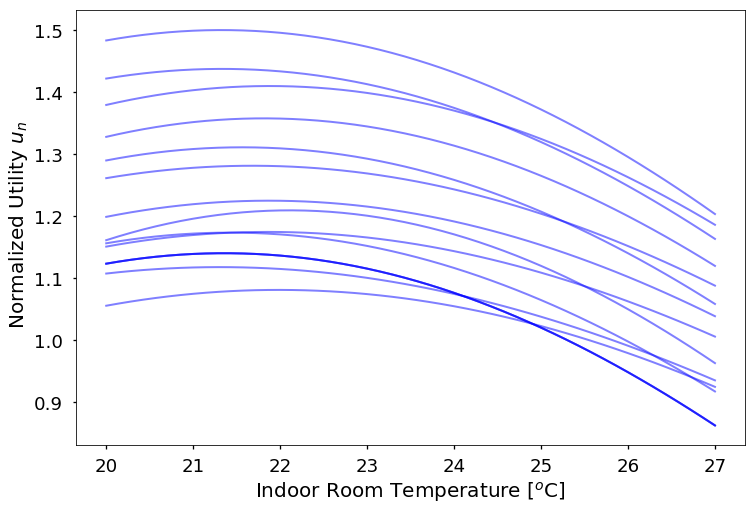

In [19]:
mini = 935
maxi = 950
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmat[i,:], varmat[i,:])
#plt.legend(loc = 'best')

In [20]:
model

Name,values,prior,constraint
unimodal_model.Vf,[[ 0.72709549] [-0.15133835] [ 0.23919031] [ 1.01687797] [-0.81726618] [ 1.9099244 ] [-0.56364174] [ 0.42685591] [-0.03553704] [-0.57190651] [-0.68911149] [ 0.1957448 ] [ 0.12480292] [-1.67334818] [ 0.80476577] [ 0.80345038] [ 0.10117976] [-1.17890746] [ 0.4163683 ] [ 0.34989162] [-1.6464647 ] [ 0.49453716] [-0.13364058] [-1.05213572] [-1.77016776] [ 0.64522101] [-1.53115807] [-0.2750251 ] [-0.42533345] [ 0.59960808] [ 0.36609994] [ 1.17059921] [ 0.20047014] [-0.58703061] [ 0.53469956] [ 1.94462947] [ 0.5700972 ]],"N([ 0.],[ 1.])",(none)
unimodal_model.Vfdd,[[ 11.76248472] [ -4.81085087] [ -0.85501797] [ 1.41100949] [ -2.00912371] [ -8.30357611] [ 12.67321272] [ 1.83929366] [ 2.63964932] [ 7.25536978] [ 10.80181664] [ 0.67992628] [ 10.8129922 ] [ 2.51266597] [ 9.17824776] [-12.69425284] [ 5.01076248] [ 0.65749928] [ 4.00693408] [ -3.00487756] [ 9.60575655] [ -5.51645443] [ -5.9272257 ] [ 2.38023273] [ 7.27369931] [ 0.20243077] [ 23.0004311 ] [ -4.52473616] [-10.18792575] [ 12.89987538] [ -5.94350472] [ -0.76283854] [ 1.50951832] [ 3.60015172] [ -6.66520348]],None,(none)
unimodal_model.Vg,[[ 1.24313206e+00] [ -8.48995907e-01] [ -9.56734391e-02] [ -1.64621276e+00] [ 9.89085920e-01] [ 8.65447004e-02] [ 5.54777031e-01] [ -7.01668444e-01] [ -9.25510354e-01] [ 5.44901561e-01] [ -1.18078688e-01] [ 6.22921211e-01] [ 3.49881087e-01] [ -1.73496243e+00] [ 3.25461893e-01] [ -7.11236711e-01] [ -7.67855307e-01] [ -2.82632278e-02] [ 5.35698488e-01] [ -1.42548797e+00] [ -2.15207548e+00] [ 5.52663727e-01] [ 2.78036812e-01] [ 1.20877816e-01] [ 1.32319807e+00] [ 3.77579998e-01] [ -6.89123630e-01] [ 1.36568399e+00] [ -8.35112630e-01] [ 9.23960327e-01] [ 1.62800833e-03] [ -1.74066563e-01] [ -1.46988967e+00] [ 2.27859845e+00] [ -2.31042755e-01] [ 2.04314972e-01] [ 1.15407769e+00] [ -1.45572381e-01] [ -1.79408188e+00] [ -7.96642444e-01] [ -4.63823741e-01] [ -1.82616031e-01] [ 2.62613670e+00] [ 1.97331623e+00] [ -6.90203820e-01] [ -1.46844232e+00] [ -3.47919442e-03] [ -1.39948386e+00] [ -9.57122995e-02] [ -1.37200187e+00] [ 4.54712147e-01] [ 3.25355832e-01] [ -4.49037772e-01] [ -9.56949899e-01] [ -3.28524281e-01] [ 6.52488210e-01] [ 9.09695842e-02] [ 1.16551225e+00] [ -1.52444042e+00] [ -1.47516142e+00]],"N([ 0.],[ 1.])",(none)
unimodal_model.kern_f.lengthscale,[ 1.59321122],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_f.signal_variance,[ 1.78212811],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_g.lengthscale,[ 1.49257708],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_g.signal_variance,[ 1.54630236],"Ga([ 1.],[ 1.])",+ve
unimodal_model.likelihood.noise_variance,[ 1.20766653],None,+ve


In [21]:
from scipy.stats import norm
def diff_norm_g(m, samples, Xgridnorm, Xgrid, mini, maxi):
    """
    Different utilities along with the associated uncertainities
    """
    
    plt.figure(figsize=(12,8))
    for i in xrange(mini,maxi):
        m.set_state(samples[i,:])
        g = m.predict_g_samples(Xgridnorm, 1)
        plt.plot(Xgrid, norm.cdf(g[0,:,:]), 'b', lw=2, alpha = 0.25)
    a = np.linspace(19.8, 27.2, 100)
    plt.plot(a, 0.5*np.ones(a.shape[0]), 'r', lw = 3.,label = '$\phi(g(x)) = 0.5$')
    plt.xlim(20,27.)
    plt.xlabel('Indoor Room Temperature [$^{o}$C]')
    plt.ylabel('Latent indicator $\phi(g(\cdot))$')
    plt.legend(loc = 'best')

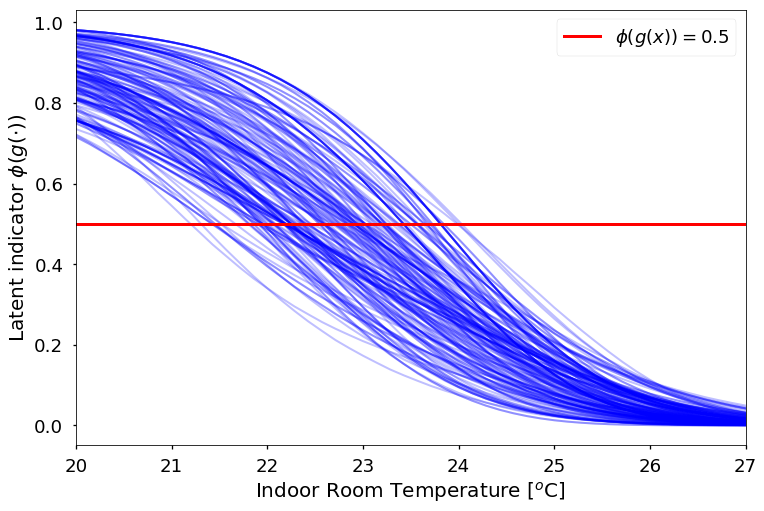

In [22]:
diff_norm_g(model, samples, xx, xnew, 1500, 1700)
plt.savefig('journal_syn/I' + occ_name + str(num_data) + '.png', dpi = 400)

In [23]:
from scipy.stats import norm
def diff_g(m, samples, Xgridnorm, Xgrid, mini, maxi):
    """
    Different utilities along with the associated uncertainities
    """
    plt.figure(figsize=(12,8))
    for i in xrange(mini,maxi):
        m.set_state(samples[i,:])
        g = m.predict_g_samples(Xgridnorm, 1)
        plt.plot(Xgrid, g[0,:,:],  'b', lw=2, alpha = 0.25)
    a = np.linspace(19.8, 27.2, 100)
    plt.plot(a, np.zeros(a.shape[0]), 'r', lw = 3.)
    plt.xlabel('Indoor Room Temperature [$^{o}$C]')
    plt.ylabel('Latent GP $g(\cdot)$')
    #plt.title('Latent g at different temp values')
    plt.xlim(20,27.)

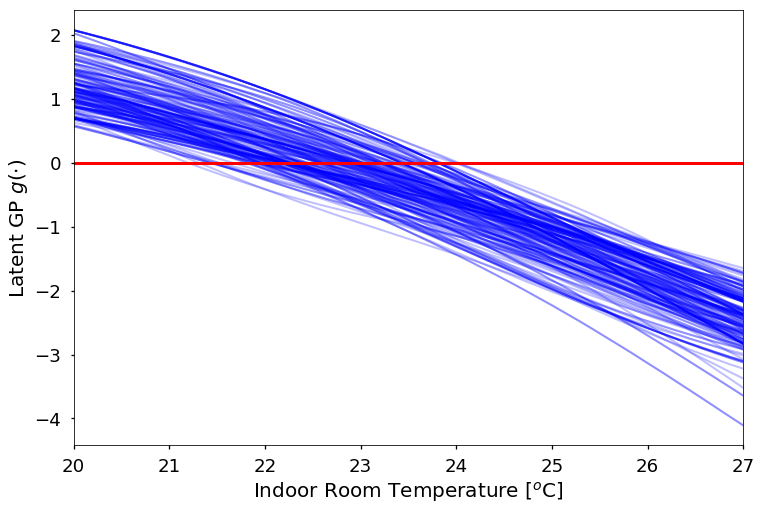

In [24]:
diff_g(model, samples, xx, xnew, 1500, 1700)
plt.savefig('journal_syn/G' + occ_name + str(num_data) + '.png', dpi = 400)

In [25]:
model.set_state(samples[2])
model

Name,values,prior,constraint
unimodal_model.Vf,[[ 0.68077864] [-0.05121413] [ 0.71751345] [-0.92352748] [ 0.64668274] [ 0.18086112] [-0.12334788] [-0.87274379] [ 0.44370523] [ 0.0042411 ] [-0.73209878] [-0.89350943] [ 0.53236725] [ 0.81707496] [-0.30107134] [-0.41475521] [-0.49920898] [ 0.84645469] [ 0.55631971] [ 0.59779227] [-0.56983787] [-0.15006979] [-1.03237897] [-0.52041498] [ 1.02469656] [-0.16576961] [ 0.30484074] [ 2.10067004] [-0.57868361] [-1.05262356] [ 1.13300018] [-0.06002087] [ 1.34823418] [-0.18757723] [-1.06879594] [ 0.20901753] [-1.82508578]],"N([ 0.],[ 1.])",(none)
unimodal_model.Vfdd,[[ 1.44945137e-01] [ 3.34133748e-03] [ 3.34001146e+00] [ 7.38019322e+00] [ -5.00746501e-01] [ -3.85049962e+00] [ 6.25837735e+00] [ -2.39062367e+00] [ 3.29862360e+00] [ -1.09670901e+00] [ 4.68493913e-01] [ -1.92620647e+00] [ -1.50949952e+00] [ -1.17116806e+00] [ 3.00146831e-01] [ -2.77552551e+00] [ -6.24774488e+00] [ 5.46734188e+00] [ -5.03566172e-01] [ 6.16720841e+00] [ 3.81471617e+00] [ 1.26916678e+00] [ -2.38756006e+00] [ -8.17413862e+00] [ 7.31488223e+00] [ -2.62403988e+00] [ 6.05170957e+00] [ 1.54890399e+00] [ 2.21310474e+00] [ 5.02127327e+00] [ -3.13186272e+00] [ 6.53970498e+00] [ 9.81323375e-01] [ 4.99305243e+00] [ -2.70884637e-01]],None,(none)
unimodal_model.Vg,[[ 2.06937616] [-1.75167916] [-1.27242497] [-0.55643722] [-0.75263547] [ 0.18549737] [ 0.71427618] [-1.39976131] [-0.35272849] [ 0.48459521] [-1.45133572] [-1.27509177] [-1.11392301] [ 0.56297137] [-1.5314101 ] [-0.27417262] [-0.14466588] [-0.14655194] [ 0.82255327] [ 1.55196033] [-0.41848307] [-0.06893877] [ 0.03258602] [-0.6052825 ] [-1.75430717] [-0.44424686] [ 0.00695845] [-0.04887357] [-2.00534675] [ 0.83381648] [ 0.33998594] [ 1.43393269] [-1.67758922] [ 1.5404076 ] [ 0.51783436] [-0.780752 ] [-1.31202381] [ 0.25982134] [ 0.172764 ] [ 1.14119023] [ 2.32668397] [-0.90802641] [ 0.12369811] [-2.14010204] [ 0.7031457 ] [-1.02401542] [ 0.23682864] [ 0.23292774] [-1.12835513] [-0.31165659] [ 0.73866836] [ 1.06295885] [ 1.46076924] [ 1.98754556] [ 0.43456515] [-0.87583673] [-0.90985684] [-1.6396076 ] [ 0.56179776] [-0.44661741]],"N([ 0.],[ 1.])",(none)
unimodal_model.kern_f.lengthscale,[ 2.68147861],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_f.signal_variance,[ 3.83164448],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_g.lengthscale,[ 1.81459815],"Ga([ 1.],[ 1.])",+ve
unimodal_model.kern_g.signal_variance,[ 1.92551572],"Ga([ 1.],[ 1.])",+ve
unimodal_model.likelihood.noise_variance,[ 0.03962574],None,+ve


In [26]:
sample_df = model.get_samples_df(samples)
sample_df.head()

,unimodal_model.Vf,unimodal_model.Vfdd,unimodal_model.Vg,unimodal_model.kern_f.lengthscale,unimodal_model.kern_f.signal_variance,unimodal_model.kern_g.lengthscale,unimodal_model.kern_g.signal_variance,unimodal_model.likelihood.noise_variance
0,"[[0.410227028494], [-0.151657885292], [0.68905...","[[0.434822647179], [-0.118955868641], [3.65371...","[[1.97984278949], [-1.55702489431], [-1.340939...",[2.72577486593],[3.34783323412],[1.92031815115],[1.87089385259],[0.0434695038104]
1,"[[0.680778641476], [-0.0512141299697], [0.7175...","[[0.14494513663], [0.00334133747963], [3.34001...","[[2.06937616044], [-1.75167915691], [-1.272424...",[2.68147860936],[3.8316444841],[1.81459814912],[1.92551571559],[0.039625741374]
2,"[[0.680778641476], [-0.0512141299697], [0.7175...","[[0.14494513663], [0.00334133747963], [3.34001...","[[2.06937616044], [-1.75167915691], [-1.272424...",[2.68147860936],[3.8316444841],[1.81459814912],[1.92551571559],[0.039625741374]
3,"[[0.680778641476], [-0.0512141299697], [0.7175...","[[0.14494513663], [0.00334133747963], [3.34001...","[[2.06937616044], [-1.75167915691], [-1.272424...",[2.68147860936],[3.8316444841],[1.81459814912],[1.92551571559],[0.039625741374]
4,"[[0.680778641476], [-0.0512141299697], [0.7175...","[[0.14494513663], [0.00334133747963], [3.34001...","[[2.06937616044], [-1.75167915691], [-1.272424...",[2.68147860936],[3.8316444841],[1.81459814912],[1.92551571559],[0.039625741374]


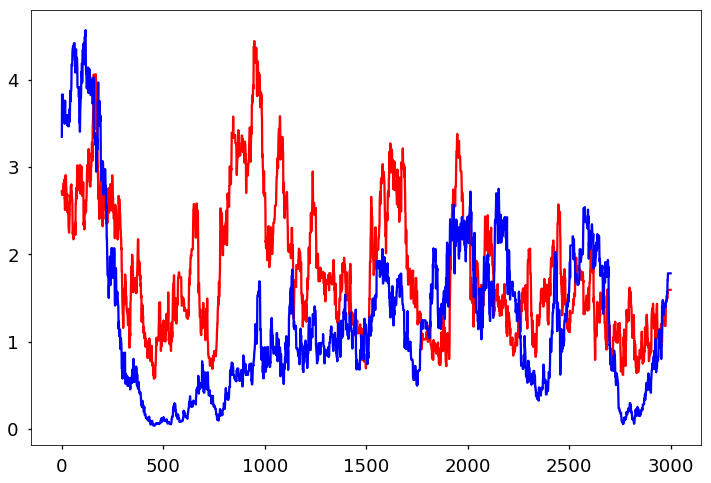

In [27]:
plt.figure(figsize=(12,8))
plt.plot(sample_df['unimodal_model.kern_f.lengthscale'], color = 'r')
plt.plot(sample_df['unimodal_model.kern_f.signal_variance'], color = 'b')

Text(0,0.5,u'signal_variance')

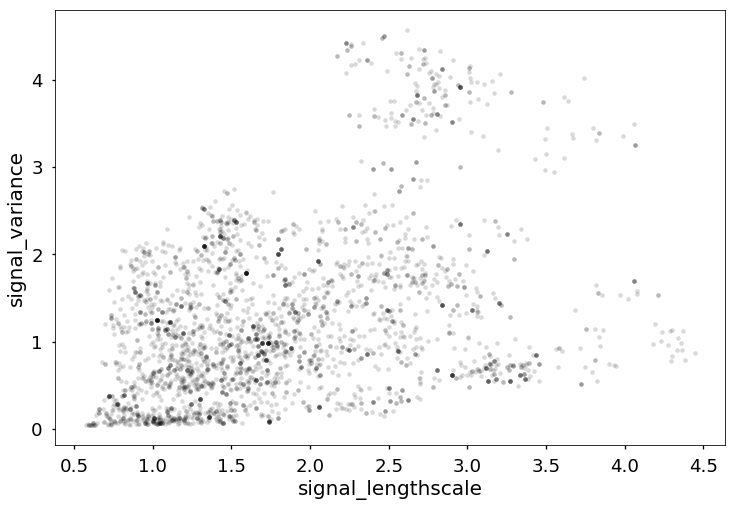

In [28]:
plt.figure(figsize=(12,8))
plt.plot(sample_df['unimodal_model.kern_f.lengthscale'],
            sample_df['unimodal_model.kern_f.signal_variance'], 'k.', alpha = 0.15)
plt.xlabel('signal_lengthscale')
plt.ylabel('signal_variance')

In [32]:
max1 = np.max(meanmat, 1)
min1 = np.min(meanmat,1)
meanmatnorm = (meanmat - min1[:,None])/(max1[:,None] - min1[:,None])

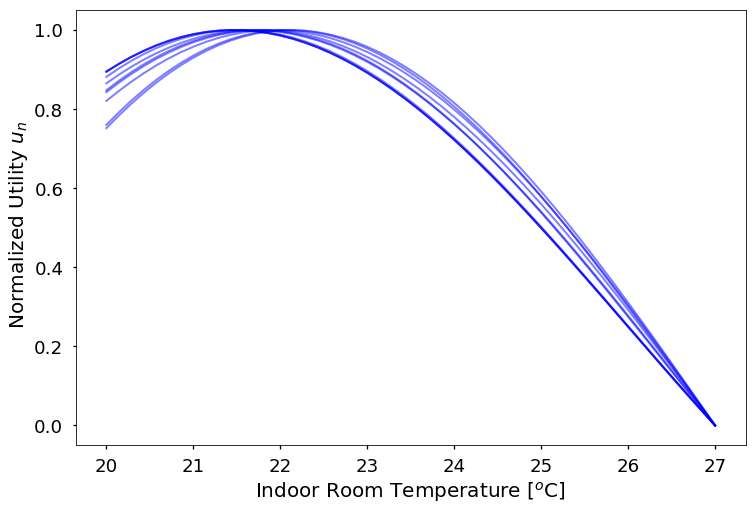

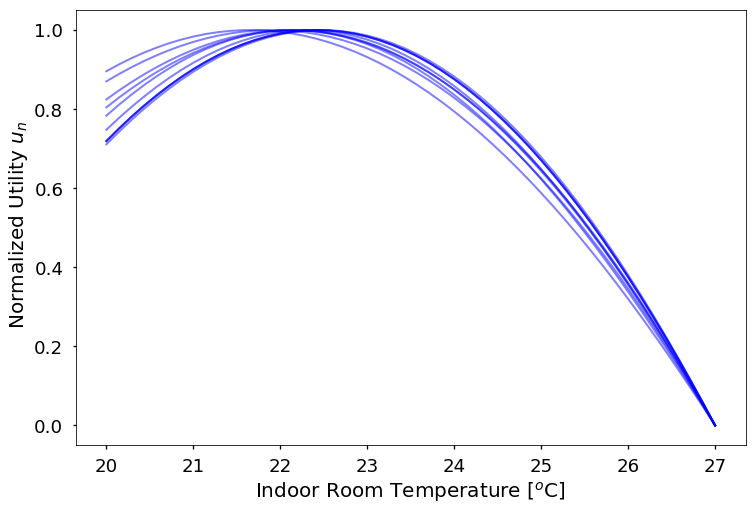

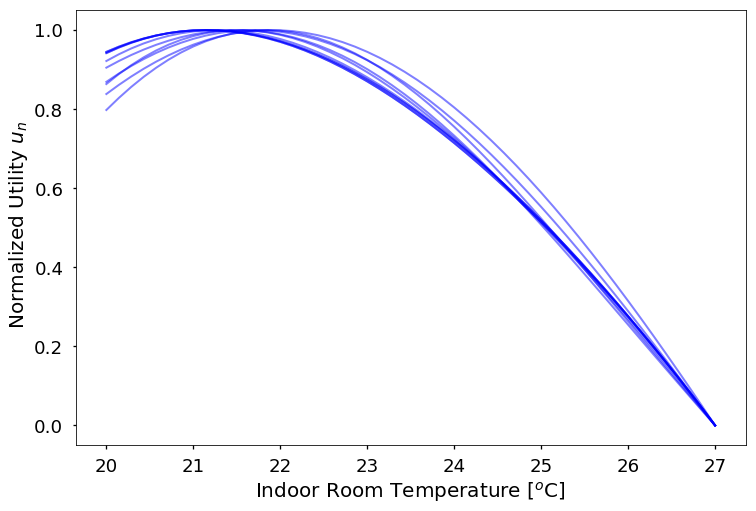

In [33]:
mini = 1120
maxi = 1130
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal/U1_' + occ_name + str(num_data) + '.png', dpi = 400)

mini = 1130
maxi = 1140
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal/U12_' + occ_name + str(num_data) + '.png', dpi = 400)

mini = 1140
maxi = 1150
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U13_' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')
#plt.legend(loc = 'best')

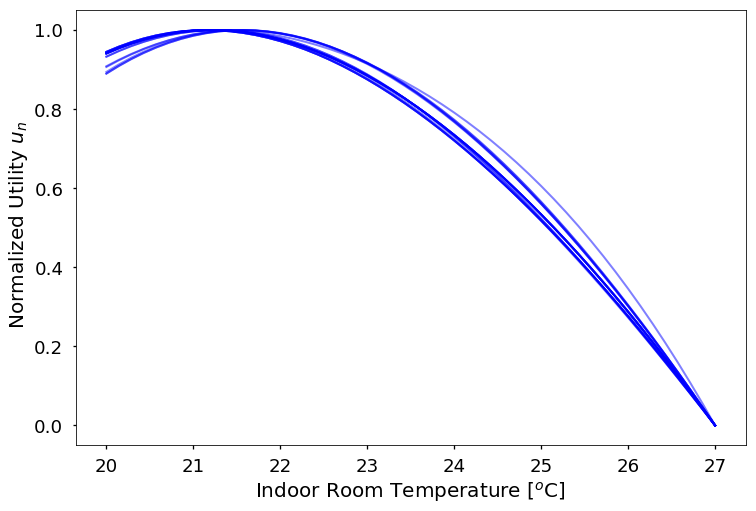

In [34]:
mini = 1150
maxi = 1170
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U11_' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')

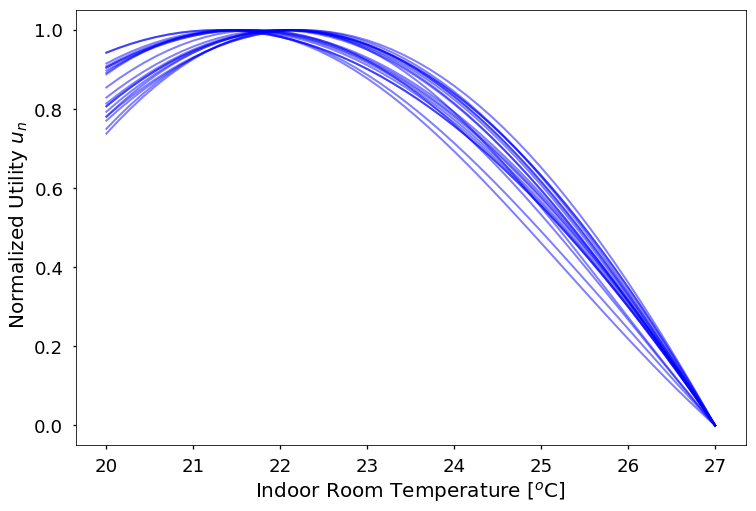

In [35]:
mini = 1170
maxi = 1190
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U2_' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')

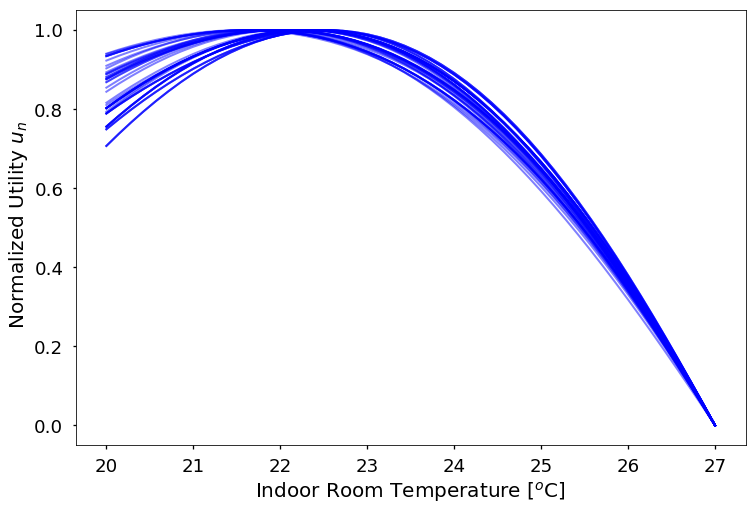

In [36]:
mini = 1700
maxi = 1750
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U21_' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')

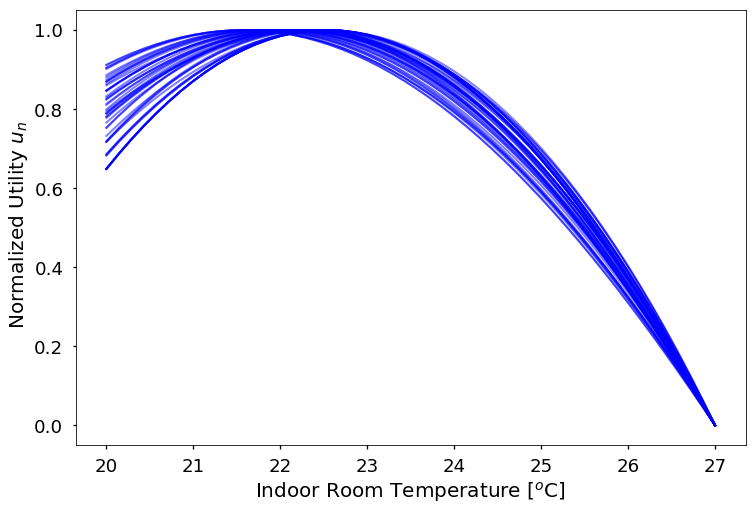

In [37]:
mini = 1550
maxi = 1600
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U3_' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')

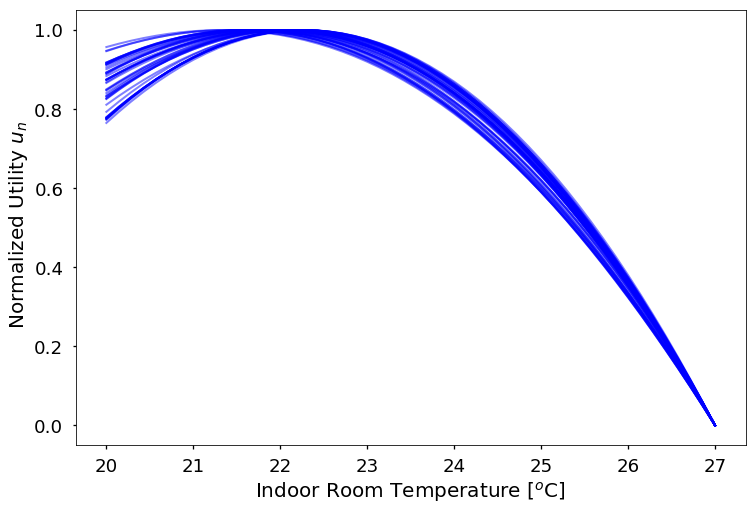

In [38]:
mini = 1650
maxi = 1700
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U31_' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')

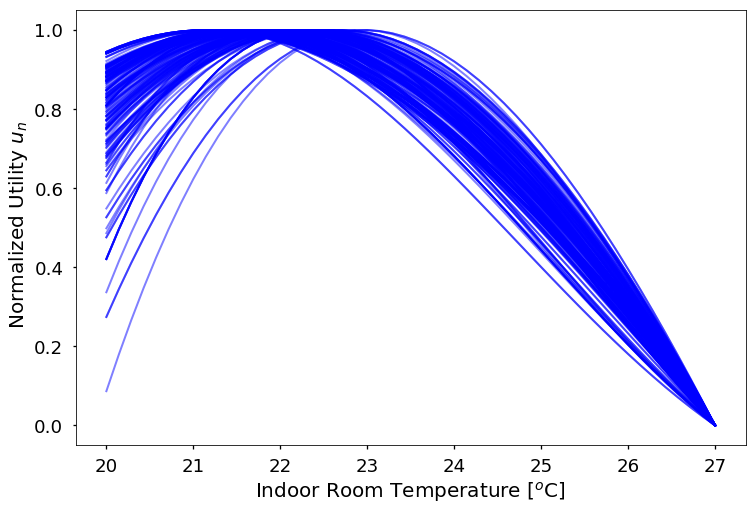

In [39]:
mini = 1000
maxi = 1200
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U4_1' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')

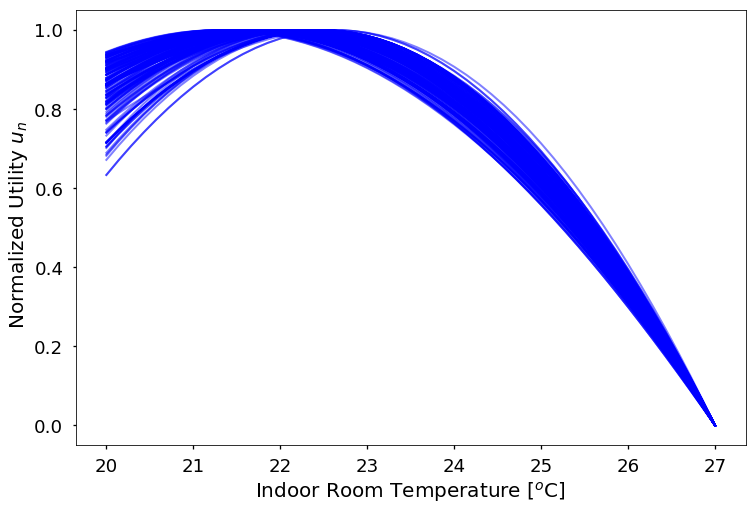

In [40]:
mini = 810
maxi = 1010
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_utility(xnew, meanmatnorm[i,:], varmat[i,:])
plt.savefig('journal_syn/U4_2' + occ_name + str(num_data) + '.png', dpi = 400)
#plt.legend(loc = 'best')

In [41]:
argmax1 = np.argmax(meanmat, 1)
posterior_max = xnew[argmax1]

In [42]:
posterior_max[:,0]

array([ 21.85714286,  22.42857143,  22.42857143, ...,  22.57142857,
        22.57142857,  22.57142857])

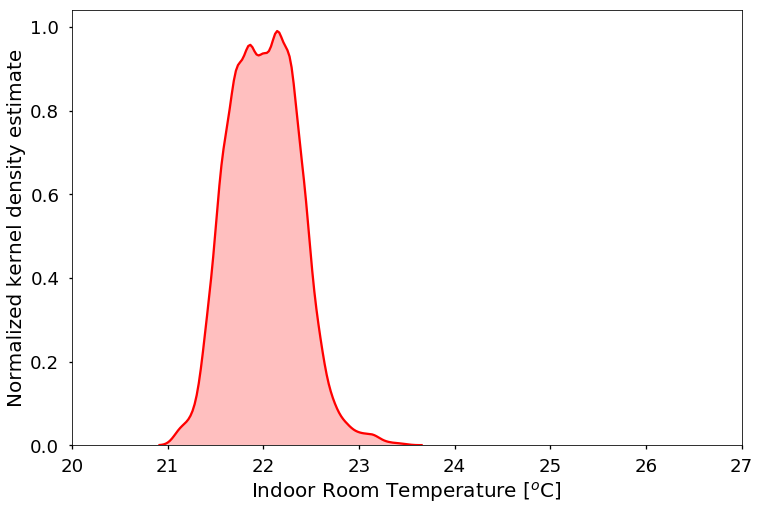

In [43]:
import seaborn as sns
sns.set_context('talk', font_scale=1.4)
plt.figure(figsize=(12,8))
sns.kdeplot(posterior_max[:,0], shade=True, color="r")
plt.xlabel('Indoor Room Temperature [$^{o}$C]')
plt.ylabel('Normalized kernel density estimate')
plt.xlim(20,27)
plt.savefig('journal_syn/M' + occ_name + str(num_data) + '.png', dpi = 400)